# Train BigTransfer on Flower Dataset

## Initial-Setup

In [1]:
!nvidia-smi

Sun Aug  1 17:08:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 679 kB 13.9 MB/s 


## Import the necessary modules

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
import tensorflow_hub as hub
import tensorflow_addons as tfa

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Fix the random seeds
SEEDS=666

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

## Data Gathering

Importing the Flower Dataset

In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


#### Define the class

In [5]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Count of Training and Validation Samples

In [6]:
print("Number of Training Samples: ",len(train_ds))
print("Number of Validation Samples: ",len(validation_ds))

Number of Training Samples:  3120
Number of Validation Samples:  550


### Visualise the Dataset

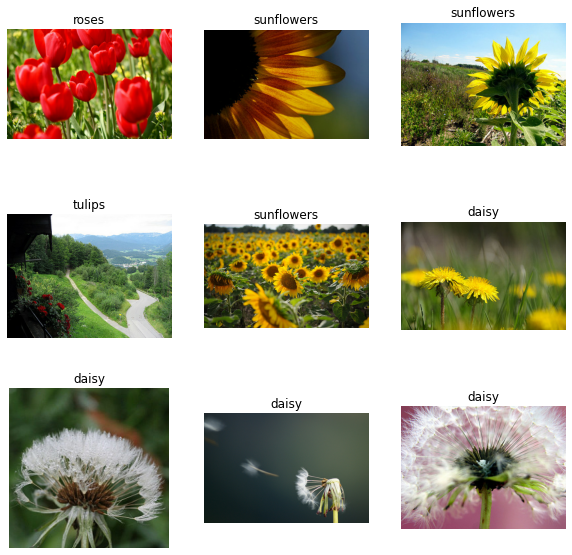

In [7]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

## Training setup

In [8]:
#@title Set dataset-dependent hyperparameters

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

## Define the Hyperparameters

In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 5
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
STEPS_PER_EPOCH = 10
DATASET_NUM_TRAIN_EXAMPLES = len([image for image in train_ds])
AUTO = tf.data.AUTOTUNE
CSV_PATH = 'train_bit.csv'

## Dataloader Function

In [10]:
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Create the Data Pipeline

In [11]:
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(
        int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)
        + 1
        + 50
    )
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

pipeline_test = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the dataset

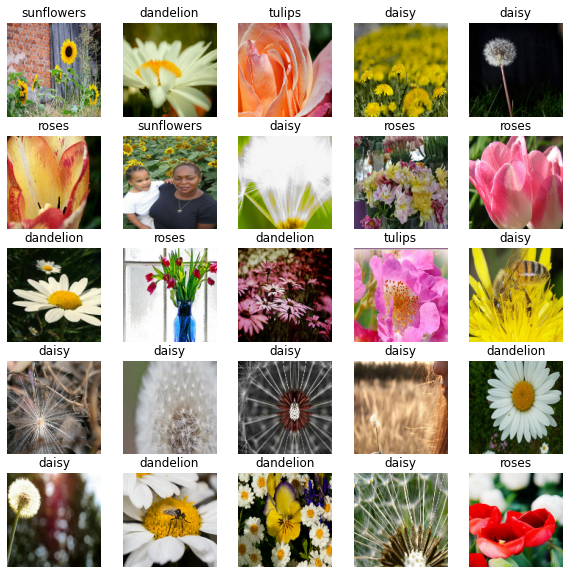

In [12]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASSES[label_batch[n].numpy()])
    plt.axis('off')

## Load model into KerasLayer

In [13]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)

## BiT Model

In [14]:
class MyBiTModel(tf.keras.Model):
  def __init__(self, module):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(128)
    self.normalize = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    dense1_representations = self.dense1(bit_embedding)
    return self.normalize(dense1_representations)

model = MyBiTModel(module=module)

## Define the optimiser and loss

In [15]:
lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tfa.losses.TripletSemiHardLoss()

### Compile the Model

In [16]:
model.compile(optimizer=optimizer, loss=loss_fn)

## Setting up Callback

In [17]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode="auto", restore_best_weights=True),
    tf.keras.callbacks.CSVLogger(CSV_PATH),
]

## Plot the results

In [18]:
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()

## Train the `BiT` Model

Training started!
Epoch 1/400
10/10 [==============================] - 38s 550ms/step - loss: 0.9411 - val_loss: 0.9189
Epoch 2/400
10/10 [==============================] - 2s 199ms/step - loss: 0.9184 - val_loss: 0.8838
Epoch 3/400
10/10 [==============================] - 2s 198ms/step - loss: 0.8733 - val_loss: 0.8408
Epoch 4/400
10/10 [==============================] - 2s 200ms/step - loss: 0.8290 - val_loss: 0.7837
Epoch 5/400
10/10 [==============================] - 2s 196ms/step - loss: 0.7875 - val_loss: 0.7252
Epoch 6/400
10/10 [==============================] - 2s 197ms/step - loss: 0.7308 - val_loss: 0.6644
Epoch 7/400
10/10 [==============================] - 2s 199ms/step - loss: 0.6453 - val_loss: 0.5985
Epoch 8/400
10/10 [==============================] - 2s 200ms/step - loss: 0.5790 - val_loss: 0.5468
Epoch 9/400
10/10 [==============================] - 2s 197ms/step - loss: 0.5538 - val_loss: 0.4945
Epoch 10/400
10/10 [==============================] - 2s 196ms/step - lo

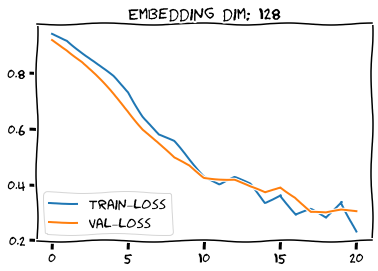

In [19]:
print("Training started!")

start = time.time()
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  
    validation_data=pipeline_test,
    callbacks=train_callbacks                                   
)

end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 128)

## Save the `BiT` model

In [20]:
KERAS_FILE = "model_bit.h5"
model.save_weights(KERAS_FILE)

In [22]:
!cp -r '/content/model_bit.h5' '/content/drive/MyDrive/Similar-Image-Search/'

In [23]:
!cp -r '/content/train_bit.csv' '/content/drive/MyDrive/Similar-Image-Search/'

Saved the Model